In [1]:
# Importando as bibliotecas e módulos
import pandas as pd
import numpy as np
from asd import dataset, utilits, metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.metrics

In [2]:
# Criando dataframe
df = dataset.autism()
# Tratamento dos dados
X,Y = dataset.basicResourceEngineering(df)

In [3]:
# Variáveis Independentes
X.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,1,1,0,0,1,1,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0
3,0,1,0,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1


In [4]:
# Variável Dependente
Y.head()

0    Sem_Autismo
1    Sem_Autismo
2    Sem_Autismo
3    Sem_Autismo
4        Autismo
Name: Class/ASD, dtype: object

# KNN - K Nearest Neighbors

**Funcionamento:** O KNN é um algoritmo supervisionado que pode ser construído tanto para Classificação quanto para Regressão. Seu funcionamento é bem simples:

**1.** Calcula-se a distância entre a nova observação e as demais;

**2.** Ordena-se todas as distâncias de forma Crescente ou Decrescente, dependendo da aplicação;

**3.** Retorna as K melhores observações que tiveram as melhores distâncias.


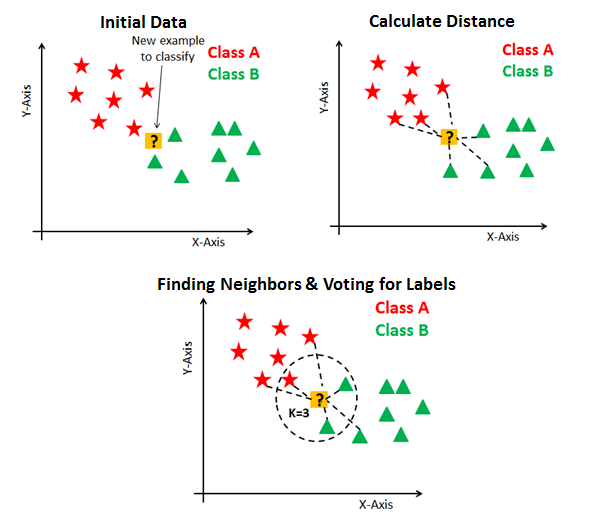

In [5]:
# Modelo
knn = KNeighborsClassifier()
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [33]:
# Seleção do Melhor K e melhor Distância
# A formulado cálculo da distância é Minkowski, ou seja:

# P = 2 -> Cálculo da distância Euclidiana
# P = 1 - > Calculo da distância de Manhatan

kGroup = [1,2,3,4,5,6,7,8,9,10]
leafGroup = [1,2,3,4,5,6]

In [43]:
# Validação cruzada
def crossValidation(model,X,Y,splits):
    metricas = []
    i = 0
    skf = StratifiedKFold(n_splits = splits, shuffle = True, random_state = 1)
    # Separando as bases de treino e teste
    for train,test in skf.split(X,Y):
        # Dicionaro de treino
        train_x, test_x = X.iloc[train], X.iloc[test]
        train_y, test_y = Y.iloc[train], Y.iloc[test]
        aux = model.fit(train_x,train_y)
        rst = aux.predict(test_x)
        metricas.append(metrics.classification_report(test_y, rst))
        i+=1
    return metricas

In [35]:
optimizerParams = {'k':[],'leaf':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
splits = 5
# Otimização de parâmetros
for k in kGroup:
    for leaf in leafGroup:
        knn = KNeighborsClassifier(n_neighbors = k, leaf_size = leaf)
        metricas = crossValidation(knn,X,Y,splits)
        optimizerParams['k'].append(k)
        optimizerParams['leaf'].append(leaf)
        optimizerParams['accuracy'].append(np.mean(np.array([metricas[x]['accuracy'] for x in range(5)])))
        optimizerParams['precision'].append(np.mean(np.array([metricas[x]['precision'] for x in range(5)])))
        optimizerParams['recall'].append(np.mean(np.array([metricas[x]['recall'] for x in range(5)])))
        optimizerParams['f1'].append(np.mean(np.array([metricas[x]['f1'] for x in range(5)])))
        
Optimizer = pd.DataFrame.from_dict(optimizerParams)

In [36]:
Optimizer

,k,leaf,accuracy,precision,recall,f1
0,1,1,0.803205,0.930116,0.914532,0.921450
1,1,2,0.803205,0.930116,0.914532,0.921450
2,1,3,0.803205,0.930116,0.914532,0.921450
3,1,4,0.848777,0.930645,0.943103,0.936667
4,1,5,0.848777,0.930645,0.943103,0.936667
5,1,6,0.848777,0.930645,0.943103,0.936667
6,2,1,0.921512,0.849101,0.985961,0.911860
7,2,2,0.922113,0.843987,0.985961,0.908909
8,2,3,0.922113,0.843987,0.985961,0.908909
9,2,4,0.922806,0.833039,0.985961,0.902685


In [40]:
for col in ["accuracy","precision","recall","f1"]:
    print("Combinação com melhor {}: k={} e leaf_size={} --- Score do Grupo: {}".format(col,Optimizer[Optimizer[col] == Optimizer[col].max()]["k"].unique(),Optimizer[Optimizer[col] == Optimizer[col].max()]["leaf"].unique(),Optimizer[col].max()))

Combinação com melhor accuracy: k=[10] e leaf_size=[4 5 6] --- Score do Grupo: 0.9335850467042418
Combinação com melhor precision: k=[1] e leaf_size=[4 5 6] --- Score do Grupo: 0.9306451612903226
Combinação com melhor recall: k=[ 8 10] e leaf_size=[1 2 3 4 5 6] --- Score do Grupo: 0.993103448275862
Combinação com melhor f1: k=[1] e leaf_size=[4 5 6] --- Score do Grupo: 0.9366666666666668


# SVM - Support Vector Machine

**Funcionamento:** O SVM é um modelo supervisionado de algoritmos de aprendizagem de máquina que tem como o objetivo uma região de separação que separe as duas classes de forma a formar uma melhor "margem de segurança". O tamanho dessa "margem" pode ser controlada alterando o valor de uma constante C, que ela basicamente permite a grosso modo que existam observações que "burlem" essa margem.

**Obs:** Quanto menor o valor de C menor é o tamanho da "margem", quanto maior o valor de C maior é a "margem".

**Exemplo de um SVM Linear**

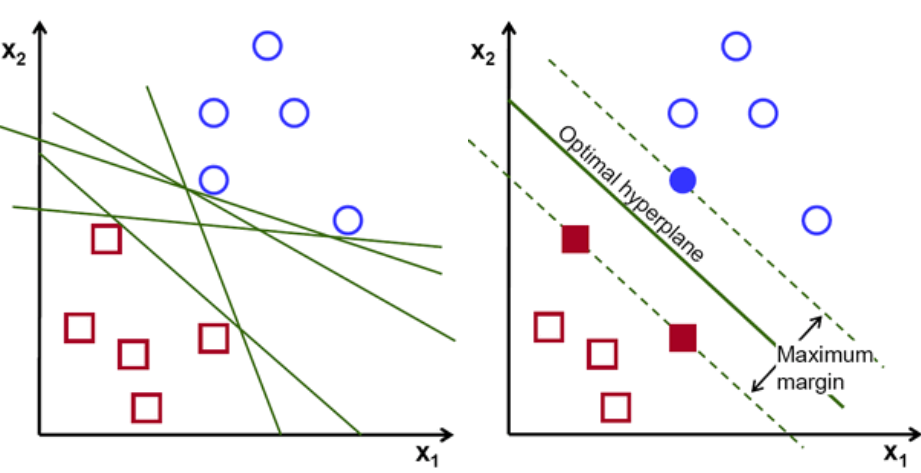

In [44]:
svm = SVC(kernel= 'linear')
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [48]:
# Selecionando o melhor valor de C

C = [0.01,0.1,1,10,50,100]
kernels = ["linear","poly","rbf","sigmoid"]

In [49]:
optimizerParams = {'kernel':[],'C':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
splits = 5
# Otimização de parâmetros
for kernel in kernels:
    for c in C:
        svm = SVC(kernel= kernel, C = c)
        metricas = crossValidation(svm,X,Y,splits)
        optimizerParams['kernel'].append(kernel)
        optimizerParams['C'].append(c)
        optimizerParams['accuracy'].append(np.mean(np.array([metricas[x]['accuracy'] for x in range(5)])))
        optimizerParams['precision'].append(np.mean(np.array([metricas[x]['precision'] for x in range(5)])))
        optimizerParams['recall'].append(np.mean(np.array([metricas[x]['recall'] for x in range(5)])))
        optimizerParams['f1'].append(np.mean(np.array([metricas[x]['f1'] for x in range(5)])))
        
Optimizer = pd.DataFrame.from_dict(optimizerParams)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jovyan/work/asd/metrics.py:71: RuntimeWarning: invalid value encountered in long_scalars
  metrics["precision"] = tp / (tp + fp)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jovyan/work/asd/metrics.py:71: RuntimeWarning: invalid value encountered in long_scalars
  metrics["precision"] = tp / (tp + fp)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from '

/home/jovyan/work/asd/metrics.py:71: RuntimeWarning: invalid value encountered in long_scalars
  metrics["precision"] = tp / (tp + fp)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jovyan/work/asd/metrics.py:71: RuntimeWarning: invalid value encountered in long_scalars
  metrics["precision"] = tp / (tp + fp)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from '

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [50]:
Optimizer

,kernel,C,accuracy,precision,recall,f1
0,linear,0.01,0.890307,0.940169,0.971675,0.955198
1,linear,0.10,0.912331,0.965961,0.985714,0.975555
2,linear,1.00,0.933763,1.000000,1.000000,1.000000
3,linear,10.00,0.933763,1.000000,1.000000,1.000000
4,linear,50.00,0.933763,1.000000,1.000000,1.000000
5,linear,100.00,0.933763,1.000000,1.000000,1.000000
6,poly,0.01,0.000000,NaN,0.000000,NaN
7,poly,0.10,0.572650,1.000000,0.751232,0.856536
8,poly,1.00,0.886139,1.000000,0.971429,0.985043
9,poly,10.00,0.933763,1.000000,1.000000,1.000000
